<a href="https://colab.research.google.com/github/1y33/Deep-Learning/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [113]:
from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


path2style = "./data/style.jpg"
path2content = "./data/content.jpg"

content_img = Image.open(path2content)
style_img = Image.open(path2style)

content_img.size

(750, 422)

In [114]:
import torchvision.transforms as transforms

h,w = content_img.size

mean_rgb = (0.485,0.456,0.406)
std_rgb = (0.229,0.224,0.225)

transformer = transforms.Compose([
    transforms.Resize((w,h)),
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb,std_rgb),
])

content_tensor = transformer(content_img)
style_tensor = transformer(style_img)



In [115]:
import torch
from torchvision.transforms.functional import to_pil_image

def img_tensor_2_pil(img_tensor):
  img_tensor_c = img_tensor.clone().detach()
  img_tensor_c*=torch.tensor(std_rgb).view(3,1,1)
  img_tensor_c+=torch.tensor(mean_rgb).view(3,1,1)
  img_tensor_c = img_tensor_c.clamp(0,1)
  img_pil = to_pil_image(img_tensor_c)

  return img_pil

(-0.5, 749.5, 421.5, -0.5)

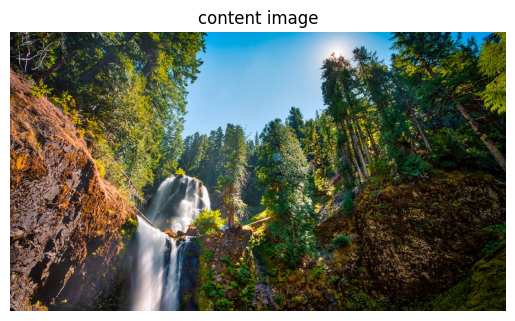

In [138]:
import matplotlib.pyplot as plt


plt.imshow(img_tensor_2_pil(content_tensor))
plt.title("content image")
plt.axis(False)

(-0.5, 749.5, 421.5, -0.5)

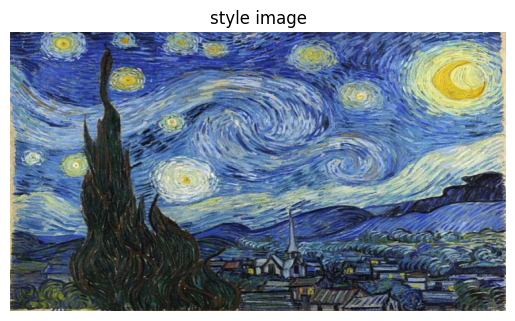

In [139]:
plt.imshow(img_tensor_2_pil(style_tensor))
plt.title("style image")
plt.axis(False)

In [118]:
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

model_vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

In [119]:
model_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [120]:
for param in model_vgg.parameters():
  param.requires_grad_(False)

In [121]:
def get_features(x,model,layers):
  features = {}
  for name, layer in enumerate(model.children()):
    x = layer(x)
    if str(name) in layers:
      features[layers[str(name)]]=x

  return features

In [122]:
def gram_matrix(x):
  n,c,h,w = x.size()
  x = x.view(n*c,h*w)
  gram = torch.mm(x,x.t())
  return gram

In [123]:
import torch.nn.functional as F

def get_content_loss(pred_features,target_features,layer):
  target = target_features[layer]
  pred = pred_features[layer]

  loss = F.mse_loss(pred,target)

  return loss

In [124]:
def get_style_loss(pred_features,target_features,style_layers_dict):
  loss = 0
  for layer in style_layers_dict:
    pred_fea = pred_features[layer]
    pred_gram = gram_matrix(pred_fea)
    n,c,h,w = pred_fea.shape

    target_gram = gram_matrix(target_features[layer])
    layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram,target_gram)

    loss+= layer_loss/ (n*c*h*w)

  return loss

In [125]:
feature_layers ={
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10' : 'conv3_1',
    '19' : 'conv4_1',
    '21' : 'conv4_2',
    '28' : 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor,model_vgg,feature_layers)
style_features = get_features(sty_tensor,model_vgg,feature_layers)

In [126]:
for key in content_features.keys():
  print(content_features[key].shape)

torch.Size([1, 64, 422, 750])
torch.Size([1, 128, 211, 375])
torch.Size([1, 256, 105, 187])
torch.Size([1, 512, 52, 93])
torch.Size([1, 512, 52, 93])
torch.Size([1, 512, 26, 46])


In [127]:
input_tensor = con_tensor.clone().requires_grad_(True)

In [131]:
from torch import optim

optimizer = optim.Adam([input_tensor],lr=0.01)

In [134]:
num_epochs = 301
content_weight = 1e1
style_weight = 1e5
content_layer = "conv5_1"
style_layers_dict = {
    'conv1_1' : 0.75,
    'conv2_1' : 0.5,
    'conv3_1' : 0.25,
    'conv4_1' : 0.25,
    'conv5_1' : 0.25,

}

In [140]:
for epoch in range(num_epochs+1):
  optimizer.zero_grad()
  input_features = get_features(input_tensor,model_vgg,feature_layers)

  content_loss = get_content_loss(input_features,content_features,content_layer)
  style_loss = get_style_loss(input_features,style_features,style_layers_dict)

  neural_loss = content_weight*content_loss + style_weight*style_loss
  neural_loss.backward()

  optimizer.step()

  if epoch %100 == 0:
    print(f"Epoch : {epoch}")
    print(f"Content Loss : {content_loss}")
    print(f"Style Loss : {style_loss}")
    print(" ")


Epoch : 0
Content Loss : 2.246607780456543
Style Loss : 0.1674201637506485
 
Epoch : 100
Content Loss : 2.252073049545288
Style Loss : 0.1371384561061859
 
Epoch : 200
Content Loss : 2.2548763751983643
Style Loss : 0.11626999080181122
 
Epoch : 300
Content Loss : 2.261462450027466
Style Loss : 0.09921316057443619
 


(-0.5, 749.5, 421.5, -0.5)

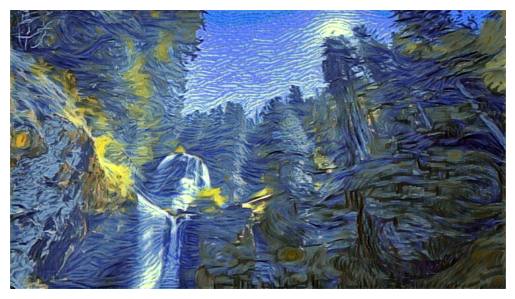

In [142]:
plt.imshow(img_tensor_2_pil(input_tensor[0].cpu()))
plt.axis(False)